In this tutorial, we start from a NumPy code and `torch.compile` it. To recap, the compilation here is a three-step process under the hood: first, NumPy constructs are converted into equivalent PyTorch calls; these Pytorch calls are then transpiled (lowered) into efficient C++ code, and finally these C++ kernels are JIT compiled into machine code. The result may give significant speedups as compared to original NumPy code, but
In this tutorial we consider a worked example of some of these transformations.


# The setup

To be specific, we start from the code to construct the Mandelbrot fractal, which we take from N. Rougier "From python to NumPy" book, [https://www.labri.fr/perso/nrougier/from-python-to-numpy/], Chapter 4.3.

To recap, the Mandelbrot fractal is a locus of complex plane of the variable `c`, for which the iteration

$$
z_0 = 0, \qquad z_{n+1} = z_n^2 + c, \qquad n=0, 1, \dots
$$

remains bounded: $z_n < \infty$ as $n\to\infty$.

The code below constructs a grid of the size $x_n \times y_n$, defined by the box $[x_{min}, x_{max}] \times [y_{min}, y_{max}]$, and for each point of this mesh, $c$, performs `maxiter` steps of the  Mandelbrot iteration.

In [29]:
import numpy as np

# from Chap 4.3, https://www.labri.fr/perso/nrougier/from-python-to-numpy/#temporal-vectorization

def mandelbrot_numpy(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon=2.0):   
    X = np.linspace(xmin, xmax, xn, dtype='float32')
    Y = np.linspace(ymin, ymax, yn, dtype='float32')
    C = X + Y[:, None]*1j
    N = np.zeros(C.shape, dtype='int')
    Z = np.zeros(C.shape, dtype='complex64')
    for n in range(maxiter):
        I = np.abs(Z) < horizon
        N[I] = n
        Z[I] = Z[I]**2 + C[I]
    N[N == maxiter-1] = 0
    return Z, N

Let's perform the iteration and visualize the result:

In [56]:
xmin, xmax, xn = -2.25, +0.75, 3000 // 3 
ymin, ymax, yn = -1.25, +1.25, 2500 // 3
maxiter = 200
horizon = 2.0 ** 40

# iterate
Z, N = mandelbrot_numpy(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon)

/tmp/ipykernel_196042/2169256356.py:10: RuntimeWarning: invalid value encountered in log2
  M = np.nan_to_num(N + 1 - np.log2(np.log(abs(Z))) + log_horizon)


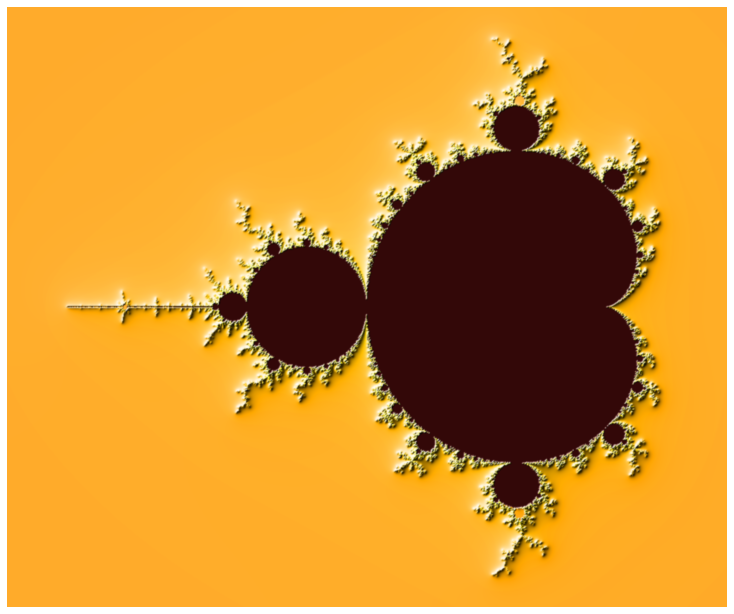

In [57]:
# plot a nice figure (see the original N. Rougier book for details)
def visualize(Z, N, horizon, xn, yn):
    log_horizon = math.log(horizon, 2)

    dpi = 72
    width = 10
    height = 10*yn/xn
                           
    # visualize (see the original version for details)
    M = np.nan_to_num(N + 1 - np.log2(np.log(abs(Z))) + log_horizon)

    dpi = 72
    width = 10
    height = 10*yn/xn

    fig = plt.figure(figsize=(width, height), dpi=dpi)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False, aspect=1)

    light = colors.LightSource(azdeg=315, altdeg=10)

    plt.imshow(light.shade(M, cmap=plt.cm.hot, vert_exag=1.5,
                           norm = colors.PowerNorm(0.3), blend_mode='hsv'),
               extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
    ax.set_xticks([])
    ax.set_yticks([])
                                   
visualize(Z, N, horizon, xn, yn)

Let's now measure the runtime of this iteration (Our aim will be to improve the this using torch.compile).

In [58]:
import time

def bench(func, name, *args):
    start_time = time.time()
    func(*args)
    end_time = time.time()
    print(f"{name} : ", end_time - start_time, "sec")

bench(mandelbrot_numpy, 'numpy', xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon)

numpy :  1.5263571739196777 sec


# Torch.compile the iteration

To improve the run time of the algorithm, we will need to apply several identical transformations. Let us work it one by one.


## 1. Extract the inner iteration and only compile it

The first thing to note is that torch dynamo agressively unrolls loops. Thus compiling the `mandelbrot` function directly would unroll the inner loop of `maxiter` iterations. This leads to very long compile times and extravagant memory consumption; on consumer grade machines compilation may even run out of memory. To avoid this, we extract the inner iteration and will only compile it, not the whole simulation:

In [4]:
def step(n, C, Z, N, horizon):
    I = np.abs(Z) < horizon
    N[I] = n
    Z[I] = Z[I]**2 + C[I]
    return Z, N


# note the additional argument, `step`
def mandelbrot(xmin, xmax, ymin, ymax, xn, yn, maxiter, step, horizon=2.0):   
    X = np.linspace(xmin, xmax, xn, dtype='float32')
    Y = np.linspace(ymin, ymax, yn, dtype='float32')
    C = X + Y[:, None]*1j
    N = np.zeros(C.shape, dtype='int')
    Z = np.zeros(C.shape, dtype='complex64')
    for n in range(maxiter):
        Z, N = step(n, C, Z, N, horizon)       
    N[N == maxiter-1] = 0
    return Z, N

In [6]:
# Set up the compilation

import torch

import torch._dynamo.config as cfg
cfg.numpy_ndarray_as_tensor = True    # this will go when torch_np is upstreamed

# make sure we all warnings from the compiler
import warnings
warnings.simplefilter('always')

# Uncomment these two lines below to see the compilation logs and more detailed feedback from the compiler
# (these will be relatively long and messy)
import logging
torch._logging.set_logs(dynamo=logging.WARNING)

The first attempt is to compile the `step` function as is. We will use the `fullgraph=True` argument to `torch.compile` so that the compilation fails on a graph break instead of falling back to eager mode.

In [7]:
step_1 = torch.compile(fullgraph=True)(step)

# run it once to warm up the JIT
mandelbrot(xmin, xmax, ymin, ymax, xn, yn, maxiter, step_1, horizon)

Unsupported: dynamic shape operator: aten.nonzero.default

from user code:
   File "/tmp/ipykernel_196042/4272750822.py", line 4, in step
    Z[I] = Z[I]**2 + C[I]

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


Indeed, the compilations fails due to a graph break. The traceback is rather messy (unfortunately, this is endemic to JIT compiler tracebacks), but the gist is that it cannot properly handle the data dependent natire of the boolean indexing. Consider a very simple example:

In [7]:
a = np.arange(3)
a[a % 2 == 0], a[a % 2 == 1]

(array([0, 2]), array([1]))

Note that the size of the array indexed by a boolean array depends on the data values in the indexer array. This sort of behavior is too dynamic for the compiler to efficiently inline into C++ code (a more precise term here is _lowering_), so that the compiler gives up and falls back to the PyTorch eager mode. Had we not explicitly asked it to fail instead (by using `fullgraph=True` parameter), the result would be not any faster than the original NumPy code.

## 2. Remove data dependence from boolean indexing

Note that we only use boolean indices, `I`, as a mask into fixed-size arrays `Z` and `N`. We however, operate on arrays of a fixed size, and only assign elements of `Z` and `N` depending on masks. This allows us to identically rewrite our code to use `np.where` instead of the boolean indexing:

In [8]:
def step_2(n, C, Z, N, horizon):
    I = np.abs(Z) < horizon
    N = np.where(I, n, N)            # N[I] = n
    Z = np.where(I, Z**2 + C, Z)     # Z[I] = Z[I]**2 + C[I]        
    return Z, N


def mandelbrot_2(xmin, xmax, ymin, ymax, xn, yn, maxiter, step, horizon=2.0):   
    X = np.linspace(xmin, xmax, xn, dtype='float32')
    Y = np.linspace(ymin, ymax, yn, dtype='float32')
    C = X + Y[:, None]*1j
    N = np.zeros(C.shape, dtype='int')
    Z = np.zeros(C.shape, dtype='complex64')
    for n in range(maxiter):
        Z, N = step(n, C, Z, N, horizon)       
    N = np.where(N == maxiter-1, 0, N)        # N[N == maxiter-1] = 0
    return Z, N

In [9]:
# compile and run the code (with a small number of iterations for now)
step_2 = torch.compile(step_2)
_ = mandelbrot_2(xmin, xmax, ymin, ymax, xn, yn, maxiter=10, step=step_2, horizon=horizon)

/home/br/mambaforge/envs/torch_nightly/lib/python3.8/site-packages/torch/_inductor/lowering.py:1302: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(
Process ForkProcess-5:
Process ForkProcess-8:
Process ForkProcess-2:
Process ForkProcess-7:
Process ForkProcess-1:
Traceback (most recent call last):
Process ForkProcess-4:
Process ForkProcess-3:
Process ForkProcess-6:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/br/mambaforge/envs/torch_nightly/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/br/mambaforge/envs/torch_nightly/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/br/mambaforge/envs/torch_nightly/lib/python3.8/multiprocessing/process.py", line 108, in run
   

## 3. Complex values not supported

The next obstacle is that our `C` array has the `complex64` dtype, and Triton (the compiler which transpiles our python code into efficient C++) does not handle complex numbers at the moment. The JIT compiler again falls back to the eager mode, and the performance is still not any better then the original.

To work around this limitation, we expand our arrays to add a length-2 dimension: instead of an complex-valued array of shape `(n1, n2)` we use an real-valued array of shape `(n1, n2, 2)`, where the last dimension holds real and imaginary parts separately.

In [10]:
x = np.linspace(xmin, xmax, xn, dtype='float32')
y = np.linspace(ymin, ymax, yn, dtype='float32')

# instead of C = X[None, :] + 1j* Y[:, None]
c = np.stack(np.broadcast_arrays(x[None, :], y[:, None]), axis=-1)
c.shape

(833, 1000, 2)

We then implement the absolute value and squaring manually:

In [11]:
def abs2(a):
    r"""abs(a)**2 replacement."""
    return a[..., 0]**2 + a[..., 1]**2


def sq2(a):
    r"""a**2 replacement."""
    z = np.empty_like(a)
    z[..., 0] = a[..., 0]**2 - a[..., 1]**2
    z[..., 1] = 2 * a[..., 0] * a[..., 1]
    return z

Taking this all together, we have

In [16]:
@torch.compile(fullgraph=True, dynamic=True)
def step_3(n, c, Z, N, horizon):
    I = abs2(Z) < horizon**2                      # Note: abs2
    N = np.where(I, n, N)                         
    Z = np.where(I[..., None], sq2(Z) + c, Z)     # Note: sq2
    return Z, N


def mandelbrot_3(xmin, xmax, ymin, ymax, xn, yn,  maxiter, step, horizon=2.0):
    x = np.linspace(xmin, xmax, xn, dtype='float32')
    y = np.linspace(ymin, ymax, yn, dtype='float32')

    c = np.stack(np.broadcast_arrays(x[None, :], y[:, None]), axis=-1)

    N = np.zeros(c.shape[:-1], dtype='int')
    Z = np.zeros_like(c, dtype='float32')

    for n in range(maxiter):
        Z, N = step(n, c, Z, N, horizon)
    N = np.where(N == maxiter-1, 0, N)
    return Z, N


Now try to run the simulation with the original value of `maxiter=200`:

In [20]:
_ = mandelbrot_3(xmin, xmax, ymin, ymax, xn, yn, maxiter=maxiter, step=step_3, horizon=horizon)

[2023-07-19 13:23:03,735] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
[2023-07-19 13:23:03,735] torch._dynamo.convert_frame: [WARNING]    function: 'step_3' (/tmp/ipykernel_196042/4181140197.py:1)
[2023-07-19 13:23:03,735] torch._dynamo.convert_frame: [WARNING] to diagnose recompilation issues, set env variable TORCHDYNAMO_REPORT_GUARD_FAILURES=1 and also see https://pytorch.org/docs/master/compile/troubleshooting.html.


Unsupported: cache_size_limit reached

## 4. Chunk the iterations

We hit an internal torch Dynamo limitation: since it aggressively unrolls all loops, it recompiles and caches a separate version of the `step_3` routine for each value of integer `n` from zero to `maxiter`. 
There are several ways around it:
- we can increase the internal cache size, this may lead to extravagant memory consumption and very long compilation times; 
- we can remove the `fullgraph=True` compilation argument. Then once the cache size is reached, further iterations would fall back to the eager mode, and this has a detremental effect on performance;

A better way is to perform iterations in chunks, which we do below.

In [25]:
@torch.compile(dynamic=True)
def step_4(n0, c, Z, N, horizon, chunksize):
    for j in range(chunksize):
        n = n0 + j                    # update the iteration counter
        I = abs2(Z) < horizon**2
        N = np.where(I, n, N)
        Z = np.where(I[..., None], sq2(Z) + c, Z)
    return Z, N


def mandelbrot_4(xmin, xmax, ymin, ymax, xn, yn,  maxiter, step, horizon=2.0):
    x = np.linspace(xmin, xmax, xn, dtype='float32')
    y = np.linspace(ymin, ymax, yn, dtype='float32')
    c = np.stack(np.broadcast_arrays(x[None, :], y[:, None]), axis=-1)

    N = np.zeros(c.shape[:-1], dtype='int')
    Z = np.zeros_like(c, dtype='float32')

    chunksize=10                                     # compile this many steps
    n_chunks = maxiter // chunksize

    for i_chunk in range(n_chunks):
        n0 = i_chunk*chunksize                       # update the iteration counter
        Z, N = step(n0, c, Z, N, horizon, chunksize)

    N = np.where(N == maxiter-1, 0, N)
    return Z, N

## Benchmark the final result

Finally, we are in position to benchmark our final result:

In [54]:
# warm up the JIT
Z, N = mandelbrot_4(xmin, xmax, ymin, ymax, xn, yn, maxiter=maxiter, step=step_4, horizon=horizon)

bench(mandelbrot_4, 'compiled_4', xmin, xmax, ymin, ymax, xn, yn, maxiter, step_4, horizon)

compiled_4 :  0.32459521293640137 sec


In [60]:
# The speedup against NumPy:

1.526357 / 0.324595

4.702342919638318

# Recap

To summarize, we started with a NumPy program which performs the Mandelbrot iteration, and used `torch.compile` to speed it up. En route, we worked around several peculiarities of the `torch.compile` toolchain, including the lack of complex number support, difficulties with compiling the data dependent control flows, and agressive unrolling of loops during compilation.

With rather mild rewrites of the original code, we got a performance increase of more than 4 times. Note that the specific performance numbers may rather strongly depend on the problem size and other details (for instance, the chunk size for splitting the iterations). Anecdotally, in other programs we saw speedups ranging from 3 to 50 depending on the problem size relative to the cache size of the target machine. Performance tuning remains an experimental activity and the outcomes very much depend on details.

Finally, we note that our mitigation tricks may be equally applicable to NumPy and PyTorch programs.